## Libs

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

## Prep funcs

In [2]:
def reduction_memory(df: pd.DataFrame) -> pd.DataFrame:
    """function for reduction memory size"""
    
    df_c = df.copy()
    
    for column in df_c.columns:
    
        series = df_c[df_c[column].notna()][column]
        
        if series.dtype == 'float64':
            if (series != series.astype('float32')).sum() == 0:
                df_c[column] = series.astype('float32')
        elif series.dtype == 'int64':
            if (series != series.astype('int8')).sum() == 0:
                df_c[column] = series.astype('int8')
            elif (series != series.astype('int16')).sum() == 0:
                df_c[column] = series.astype('int16')
            elif (series != series.astype('int32')).sum() == 0:
                df_c[column] = series.astype('int32')
                
    mb_before = df.memory_usage().sum() * 1e-6
    mb_after = df_c.memory_usage().sum() * 1e-6
    mb_reduced = mb_before - mb_after
    
    print(f'before:\t\t{round(mb_before, 2)} mb\n', 
          f'after:\t\t{round(mb_after, 2)} mb\n',
          f'reduсed:\t{round(mb_reduced, 2)} mb',
          sep='')
    
    return df_c

## Prep df

In [3]:
FILE = 'freMPL-R.csv'

In [4]:
df = pd.read_csv(FILE, low_memory=False, parse_dates=['RecordBeg', 'RecordEnd'])

df = df.loc[df.Dataset.isin([5, 6, 7, 8, 9])]

df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)

df = reduction_memory(df)

df.reset_index(drop=True, inplace=True)

df.info()

before:		19.35 mb
after:		12.32 mb
reduсed:	7.02 mb
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115155 entries, 0 to 115154
Data columns (total 20 columns):
Exposure             115155 non-null float64
LicAge               115155 non-null int16
RecordBeg            115155 non-null datetime64[ns]
RecordEnd            59455 non-null datetime64[ns]
Gender               115155 non-null object
MariStat             115155 non-null object
SocioCateg           115155 non-null object
VehUsage             115155 non-null object
DrivAge              115155 non-null int8
HasKmLimit           115155 non-null int8
BonusMalus           115155 non-null int16
ClaimAmount          115155 non-null float64
ClaimInd             115155 non-null int8
ClaimNbResp          115155 non-null float32
ClaimNbNonResp       115155 non-null float32
ClaimNbParking       115155 non-null float32
ClaimNbFireTheft     115155 non-null float32
ClaimNbWindscreen    115155 non-null float32
OutUseNb             115155 non

In [5]:
df[:5]

,Exposure,LicAge,RecordBeg,RecordEnd,Gender,MariStat,SocioCateg,VehUsage,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,ClaimNbResp,ClaimNbNonResp,ClaimNbParking,ClaimNbFireTheft,ClaimNbWindscreen,OutUseNb,RiskArea
0,0.083,332,2004-01-01,2004-02-01,Male,Other,CSP50,Professional,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
1,0.916,333,2004-02-01,NaT,Male,Other,CSP50,Professional,46,0,50,0.0,0,0.0,1.0,0.0,0.0,0.0,0.0,9.0
2,0.550,173,2004-05-15,2004-12-03,Male,Other,CSP50,Private+trip to office,32,0,68,0.0,0,0.0,2.0,0.0,0.0,0.0,0.0,7.0
3,0.089,364,2004-11-29,NaT,Female,Other,CSP55,Private+trip to office,52,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,8.0
4,0.233,426,2004-02-07,2004-05-01,Male,Other,CSP60,Private,57,0,50,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,7.0


### Предобработайте данные

In [6]:
df.loc[df['ClaimAmount'] < 0, 'ClaimAmount'] = 0
df['ClaimsCount'] = df['ClaimInd'] + df['ClaimNbResp'] + df['ClaimNbNonResp'] + \
                    df['ClaimNbParking'] + df['ClaimNbFireTheft'] + df['ClaimNbWindscreen']
df.loc[df['ClaimsCount'] > 0, 'AvgClaim'] = df['ClaimAmount']/df['ClaimsCount']
df.loc[df['ClaimAmount'] == 0, 'ClaimsCount'] = 0

df['Gender'] = df['Gender'].map({'Male':1, 'Female':2})
df['MariStat'] = df['MariStat'].map({'Other':1, 'Alone':2})
df['VehUsage'] = df['VehUsage'].map({'Professional':1, 'Private+trip to office':2, 'Private':3, 'Professional run':4})

df.drop(["ClaimNbResp", "ClaimNbNonResp", "ClaimNbParking", "ClaimNbFireTheft", 
         "ClaimNbWindscreen", 'RecordBeg', 'RecordEnd', 'SocioCateg'], axis=1, inplace=True)

df[:5]

,Exposure,LicAge,Gender,MariStat,VehUsage,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,OutUseNb,RiskArea,ClaimsCount,AvgClaim
0,0.083,332,1,1,1,46,0,50,0.0,0,0.0,9.0,0.0,0.0
1,0.916,333,1,1,1,46,0,50,0.0,0,0.0,9.0,0.0,0.0
2,0.550,173,1,1,2,32,0,68,0.0,0,0.0,7.0,0.0,0.0
3,0.089,364,2,1,2,52,0,50,0.0,0,0.0,8.0,0.0,NaN
4,0.233,426,1,1,3,57,0,50,0.0,0,0.0,7.0,0.0,NaN


### XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде [0, num_classes]. Заменим значение 11 на 10.

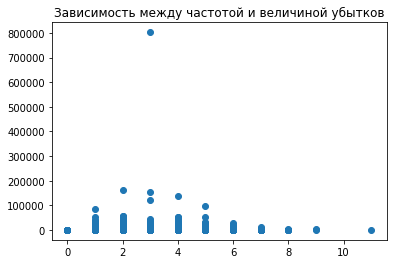

In [7]:
plt.scatter(df['ClaimsCount'], df['ClaimAmount'])
plt.title('Зависимость между частотой и величиной убытков')
plt.show()

In [8]:
df.loc[df['ClaimsCount'] == 11, 'ClaimsCount'] = 10

ff = df.loc[(df['ClaimsCount'] == 10)|(df['ClaimsCount'] == 9)|(df['ClaimsCount'] == 8)|(df['ClaimsCount'] == 7),:] 
n = 10
for i in range(n):
    df = pd.concat([df,ff])
df['ClaimsCount'].value_counts() 

0.0     104286
2.0       3529
1.0       3339
3.0       2310
4.0       1101
5.0        428
7.0        286
6.0        127
8.0         66
9.0         22
10.0        11
Name: ClaimsCount, dtype: int64

In [9]:
ff = df.loc[(df['ClaimsCount'] == 6)|(df['ClaimsCount'] == 10)|(df['ClaimsCount'] == 9)|(df['ClaimsCount'] == 8),:] 
n = 5
for i in range(n):
    df = pd.concat([df,ff])
df['ClaimsCount'].value_counts()

0.0     104286
2.0       3529
1.0       3339
3.0       2310
4.0       1101
6.0        762
5.0        428
8.0        396
7.0        286
9.0        132
10.0        66
Name: ClaimsCount, dtype: int64

### Посмотрим, сколько полисов соответствуют каждому из значений ClaimsCount, используя метод groupby. Для полученных значений также посчитаем нормированную частоту.

In [10]:
FreqCount = df[['ClaimsCount', 'ClaimInd']].groupby('ClaimsCount').count()
FreqCount.columns = ['Count']
FreqCount

,Count
ClaimsCount,
0.0,104286
1.0,3339
2.0,3529
3.0,2310
4.0,1101
5.0,428
6.0,762
7.0,286
8.0,396


In [11]:
scaler = StandardScaler()
# не знаю то или нет
FreqCount['Freq'] = scaler.fit_transform(FreqCount)
FreqCount

,Count,Freq
ClaimsCount,,
0.0,104286,3.159673
1.0,3339,-0.245002
2.0,3529,-0.238593
3.0,2310,-0.279707
4.0,1101,-0.320483
5.0,428,-0.343182
6.0,762,-0.331917
7.0,286,-0.347971
8.0,396,-0.344261


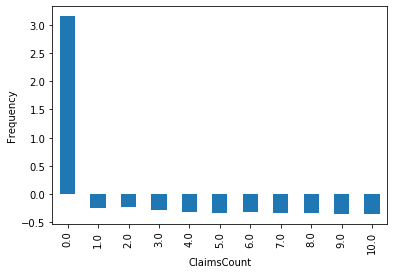

In [12]:
FreqCount['Freq'].plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

### Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец weight. Присвоим ему некоторые значения, например, можно задать 0.05 для значений ClaimsCount 0, а для остальных - 1 (Для этого можем использовать функцию np.where). Также можно попробовать какой-либо другой способ задания весов, приведенный пример не гарантирует хороших результатов.

In [13]:
df['weight'] = np.where(df['ClaimsCount'] == 0, 0.05, 1)
df[:5]

,Exposure,LicAge,Gender,MariStat,VehUsage,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,ClaimInd,OutUseNb,RiskArea,ClaimsCount,AvgClaim,weight
0,0.083,332,1,1,1,46,0,50,0.0,0,0.0,9.0,0.0,0.0,0.05
1,0.916,333,1,1,1,46,0,50,0.0,0,0.0,9.0,0.0,0.0,0.05
2,0.550,173,1,1,2,32,0,68,0.0,0,0.0,7.0,0.0,0.0,0.05
3,0.089,364,2,1,2,52,0,50,0.0,0,0.0,8.0,0.0,NaN,0.05
4,0.233,426,1,1,3,57,0,50,0.0,0,0.0,7.0,0.0,NaN,0.05


### Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [14]:
target = 'ClaimsCount'

X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=10)

### Далее, создадим объекты DMatrix для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр weight равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр data.

In [15]:
train = xgb.DMatrix(data=X_train.drop('weight', axis=1), label=y_train, weight=X_train['weight'])
valid = xgb.DMatrix(data=X_valid.drop('weight', axis=1), label=y_valid, weight=X_valid['weight'])
test = xgb.DMatrix(data=X_test.drop('weight', axis=1), label=y_test, weight=X_test['weight'])

In [16]:
print(np.unique(train.get_label()))
print(np.unique(test.get_label()))
print(np.unique(valid.get_label()))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


### Для оптимизации гиперпараметров можно воспользоваться различными методами.

In [17]:
params ={
    
    'max_depth': 3,  # глубина дерева
    'eta': 0.3,  # шаг обучения
    'num_class': 11,  # число классов
         
    'objective': 'multi:softmax',  # выход модели (фактически строим 11 моделей, но перевзвесили по софтмаксу)
    'silent':1 # молча, без логов
    
} # params

train_params = {
    
    'num_boost_round': 300,

    'maximize': False,
    'verbose_eval': False
    
} # train_params

### Далее обучим нашу модель с оптимальными параметрами

In [18]:
xgb = xgb.train(params=params, dtrain=train, early_stopping_rounds=10,
                evals=[(train, "train"), (valid, "valid")])

[16:13:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-merror:0.38371	valid-merror:0.39129
Multiple eval metrics have been passed: 'valid-merror' will be used for early stopping.

Will train until valid-merror hasn't improved in 10 rounds.
[1]	train-merror:0.31080	valid-merror:0.32336
[2]	train-merror:0.28170	valid-merror:0.29929
[3]	train-merror:0.29561	valid-merror:0.31288
[4]	train-merror:0.27677	valid-merror:0.29230
[5]	train-merror:0.25260	valid-merror:0.26901
[6]	train-merror:0.25042	valid-merror:0.26901
[7]	train-merror:0.24395	valid-merror:0.25892
[8]	train-merror:0.20580	valid-merror:0.22282
[9]	train-merror:0.22278	valid-merror:0.23912


### Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью plt.imshow(). Можно использовать предложенный ниже код.

In [19]:
dfsets = [{'set': 'train', 'dmat': train, 'target': y_train},
          {'set': 'valid', 'dmat': valid, 'target': y_valid},
          {'set': 'test', 'dmat': test, 'target': y_test}]
for dfset in dfsets:
    class_preds = xgb.predict(dfset['dmat']) # Посчитаем предсказанные значения
    print('F1 Score on ' + str(dfset['set'])+':', f1_score(dfset['target'], class_preds, average='micro')) # Посчитаем F1 Score

F1 Score on train: 0.9662436921267944
F1 Score on valid: 0.9647899399828522
F1 Score on test: 0.9658779149519892


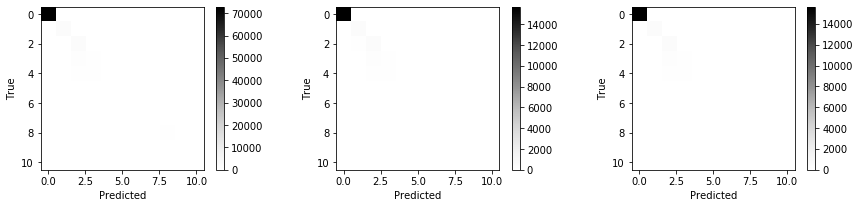

In [20]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], xgb.predict(dfsets[i]['dmat']))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

### Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

Модель показывает очень хороший результат. Но похоже, что это связано с тем, что модель очень хорошо угадывает группу 0, а остальные группы не так хорошо. Думаю здесь нужно балансировать классы, для того, что бы модель имела больше данных, по каждому классу. 